|   iter    |  target   |     C     |  epsilon  |   gamma   |
-------------------------------------------------------------
| 1         | -2.425    | 37.52     | 0.9508    | 0.732     |
| 2         | -2.554    | 59.91     | 0.1569    | 0.1561    |
| 3         | -2.452    | 5.903     | 0.8663    | 0.6012    |
| 4         | -2.612    | 70.84     | 0.02156   | 0.9699    |
| 5         | -2.558    | 83.26     | 0.2131    | 0.1819    |
| 6         | -2.566    | 18.42     | 0.3049    | 0.5248    |
| 7         | -2.57     | 43.25     | 0.2919    | 0.6119    |
| 8         | -2.565    | 14.04     | 0.2929    | 0.3664    |
| 9         | -2.466    | 45.66     | 0.7854    | 0.1998    |
| 10        | -2.449    | 51.47     | 0.5928    | 0.04655   |
| 11        | -2.447    | 51.39     | 0.6451    | 0.05812   |
| 12        | -2.532    | 48.53     | 0.4862    | 0.279     |
| 13        | -2.486    | 36.15     | 0.7275    | 0.9038    |
| 14        | -2.281    | 38.31     | 0.03416   | 0.01485   |
| 15    

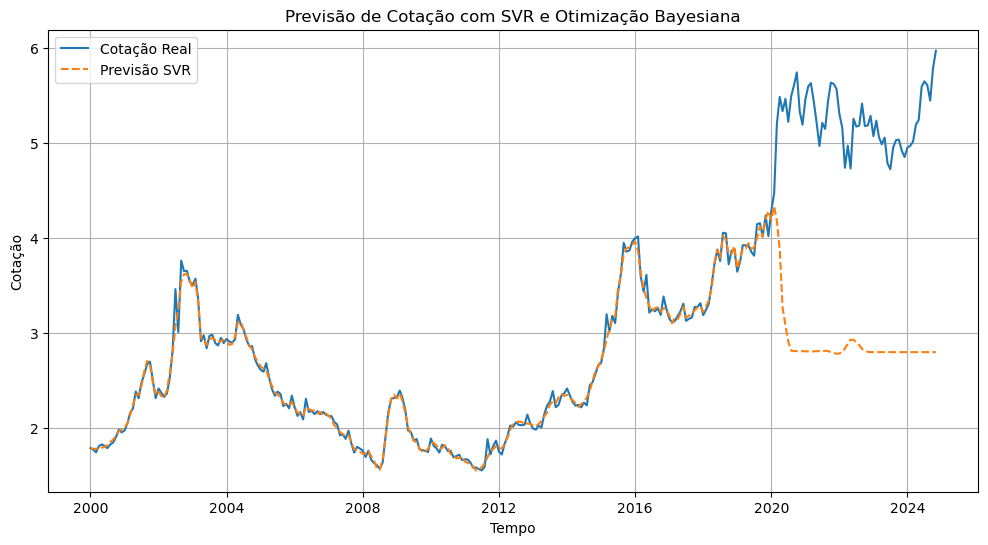

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Carregar os dados
df = pd.read_csv("./dolar_dataset_janela_6.csv")

# Criar a coluna data_formatada a partir de ano e mês
df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01")
df = df.sort_values(by="t", ascending=True)

# Definir variáveis independentes (X) e dependente (y)
X = df[['t', 'ipca_acumulado_1', 'selic_1', 'divida_pp_1', 'fed_rate_1',
        'ipca_acumulado_2', 'selic_2', 'divida_pp_2', 'fed_rate_2',
        'ipca_acumulado_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
        'ipca_acumulado_4', 'selic_4', 'divida_pp_4', 'fed_rate_4',
        'ipca_acumulado_5', 'selic_5', 'divida_pp_5', 'fed_rate_5']]
y = df['cotacao']

# Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Aplicar transformação polinomial de grau 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Padronizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Função de avaliação para otimização bayesiana
def svr_evaluate(C, epsilon, gamma):
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel="rbf")
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return -mean_absolute_error(y_test, y_pred)  # Negativo para maximizar

# Espaço de busca para os hiperparâmetros
param_bounds = {
    "C": (0.1, 100),
    "epsilon": (0.001, 1),
    "gamma": (0.0001, 1)
}

# Otimização Bayesiana
optimizer = BayesianOptimization(f=svr_evaluate, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=10, n_iter=20)

# Melhor conjunto de hiperparâmetros
best_params = optimizer.max["params"]

# Treinar modelo final com os melhores parâmetros
best_svr = SVR(C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"], kernel="rbf")
best_svr.fit(X_train_scaled, y_train)

# Previsões
df["cotacao_pred"] = best_svr.predict(scaler.transform(poly.transform(X)))

# Avaliação
mae = mean_absolute_error(y_test, best_svr.predict(X_test_scaled))
mse = mean_squared_error(y_test, best_svr.predict(X_test_scaled))
print(f"Melhores parâmetros: {best_params}")
print(f"MAE: {mae}, MSE: {mse}")

# Plotar previsões vs valores reais
plt.figure(figsize=(12, 6))
plt.plot(df["data_formatada"], df["cotacao"], label="Cotação Real")
plt.plot(df["data_formatada"], df["cotacao_pred"], label="Previsão SVR", linestyle='--')
plt.xlabel("Tempo")
plt.ylabel("Cotação")
plt.title("Previsão de Cotação com SVR e Otimização Bayesiana")
plt.legend()
plt.grid()
plt.show()


Melhores Parâmetros: {'C': 84.82645543836516, 'epsilon': 0.09107801667791422, 'gamma': 0.05732665979775677}
Mean Absolute Error (MAE): 0.12441322290228955
Mean Squared Error (MSE): 0.02922288585444439
R² Score: 0.9793192542022479


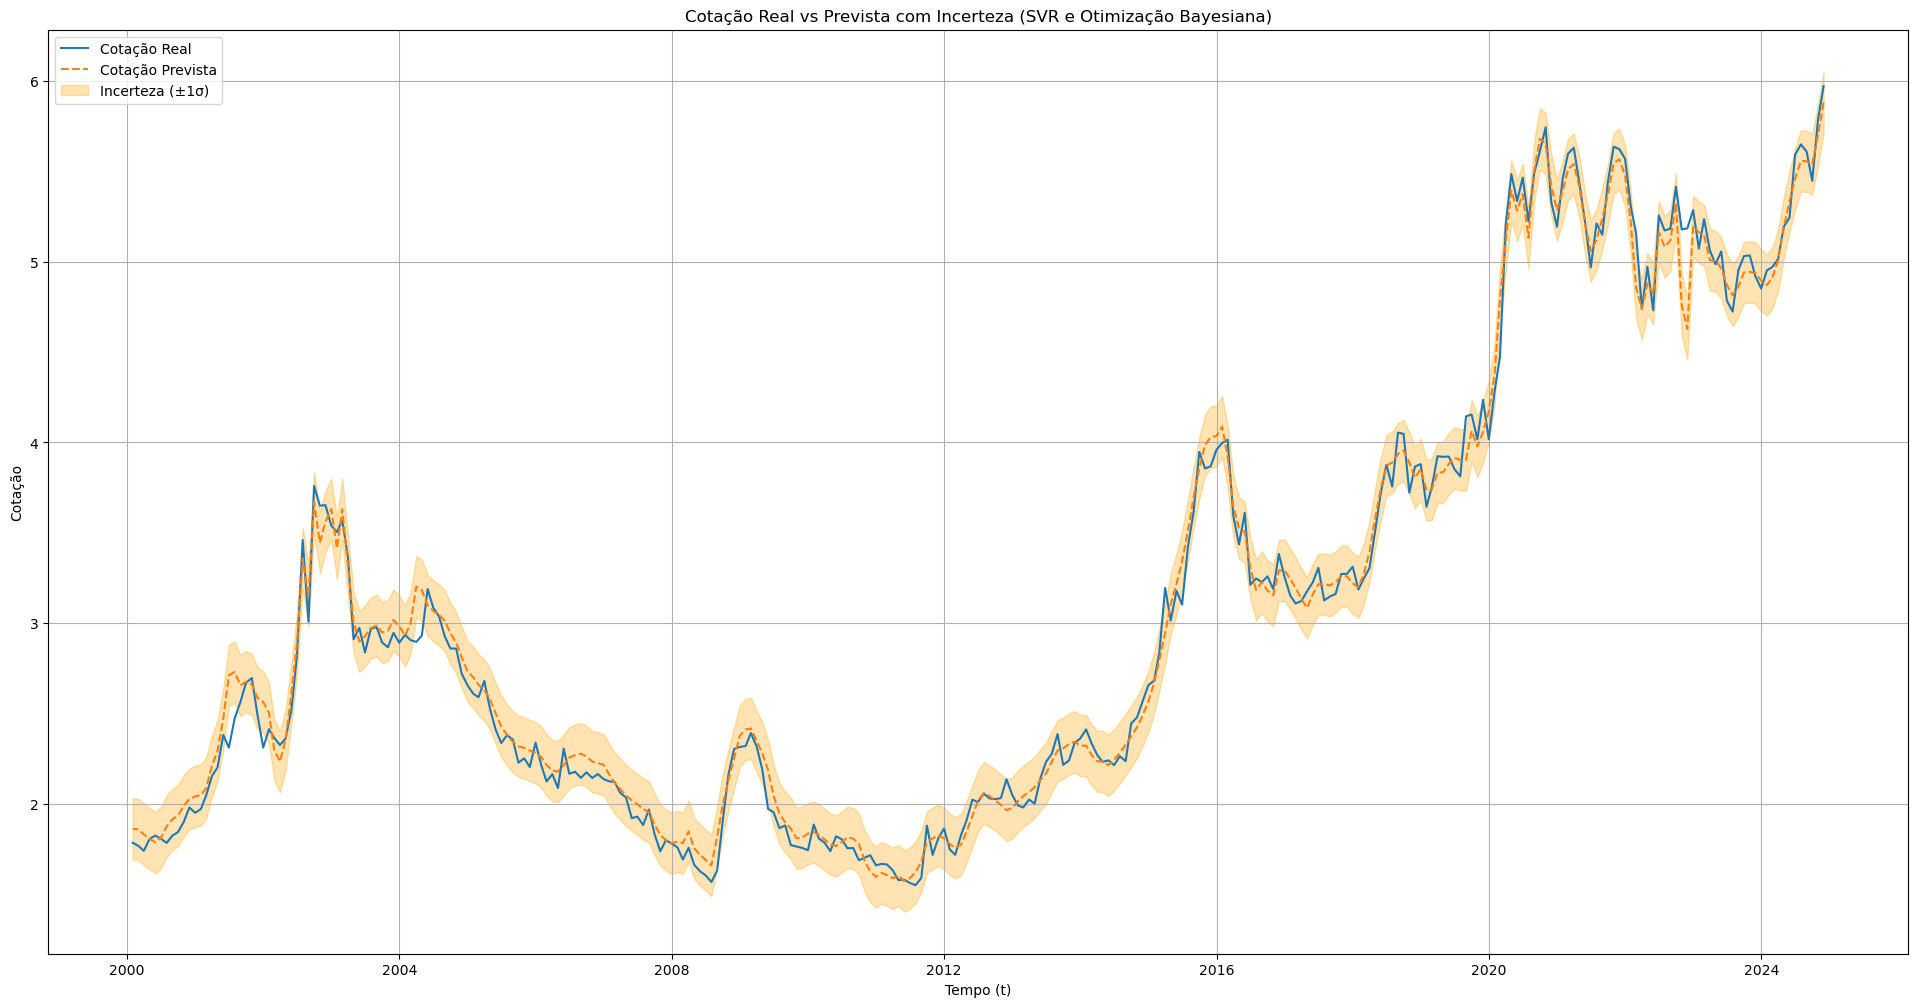

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Carregar os dados
df = pd.read_csv("./dolar_dataset_janela_6.csv")

# Criar a coluna data_formatada a partir de ano e mês
#df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01")
df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01") + pd.offsets.MonthEnd(0)


# Definir variáveis independentes (X) e dependente (y)
X = df[['t', 'ipca_acumulado_1', 'selic_1', 'divida_pp_1', 'fed_rate_1',
        'ipca_acumulado_2', 'selic_2', 'divida_pp_2', 'fed_rate_2',
        'ipca_acumulado_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
        'ipca_acumulado_4', 'selic_4', 'divida_pp_4', 'fed_rate_4',
        'ipca_acumulado_5', 'selic_5', 'divida_pp_5', 'fed_rate_5']]
y = df['cotacao']

# Transformação polinomial de grau 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_poly)

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Função de avaliação para otimização bayesiana
def svr_evaluate(C, epsilon, gamma):
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel="rbf")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -mean_absolute_error(y_test, y_pred)  # Negativo para maximizar

# Espaço de busca para os hiperparâmetros
param_bounds = {
    "C": (0.1, 100),
    "epsilon": (0.001, 1),
    "gamma": (0.0001, 1)
}

# Otimização Bayesiana
optimizer = BayesianOptimization(f=svr_evaluate, pbounds=param_bounds, verbose=0, random_state=42)
optimizer.maximize(init_points=10, n_iter=20)

# Melhor conjunto de hiperparâmetros
best_params = optimizer.max["params"]

# Treinar modelo final com os melhores parâmetros
best_svr = SVR(C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"], kernel="rbf")
best_svr.fit(X_train, y_train)

# Previsões
y_pred = best_svr.predict(X_test)

# Avaliação do modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Melhores Parâmetros: {best_params}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Calcular desvio padrão da previsão
y_std = np.std(y_pred - y_test)

# Adicionar previsões ao DataFrame original
df['cotacao_pred'] = best_svr.predict(X_scaled)

# Visualização gráfica com bandas de incerteza
plt.figure(figsize=(24, 12))
plt.plot(df['data_formatada'], df['cotacao'], label='Cotação Real')
plt.plot(df['data_formatada'], df['cotacao_pred'], label='Cotação Prevista', linestyle='--')
plt.fill_between(df['data_formatada'],
                 df['cotacao_pred'] - 1 * y_std,
                 df['cotacao_pred'] + 1 * y_std,
                 color='orange', alpha=0.3, label='Incerteza (±1σ)')
plt.xlabel('Tempo (t)')
plt.ylabel('Cotação')
plt.title('Cotação Real vs Prevista com Incerteza (SVR e Otimização Bayesiana)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Carregar os dados
df = pd.read_csv("./dolar_dataset_janela_6.csv")

# Criar a coluna data_formatada a partir de ano e mês
#df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01")
df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01") + pd.offsets.MonthEnd(0)

# Ordenar o dataframe pela data mais antiga primeiro
df = df.sort_values(by="data_formatada", ascending=True)

display(df.head())


# Definir variáveis independentes (X) e dependente (y)
X = df[['t', 'ipca_acumulado_1', 'selic_1', 'divida_pp_1', 'fed_rate_1',
        'ipca_acumulado_2', 'selic_2', 'divida_pp_2', 'fed_rate_2',
        'ipca_acumulado_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
        'ipca_acumulado_4', 'selic_4', 'divida_pp_4', 'fed_rate_4',
        'ipca_acumulado_5', 'selic_5', 'divida_pp_5', 'fed_rate_5']]
y = df['cotacao']

using_kernel = "linear"#linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

# Transformação polinomial de grau 2
poly = PolynomialFeatures(degree=1, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Padronizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Função de avaliação para otimização bayesiana
def svr_evaluate(C, epsilon, gamma):
    model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=using_kernel)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    return -mean_absolute_error(y_test, y_pred)  # Negativo para maximizar

# Espaço de busca para os hiperparâmetros
param_bounds = {
    "C": (0.1, 100),
    "epsilon": (0.001, 1),
    "gamma": (0.0001, 1)
}

# Otimização Bayesiana
optimizer = BayesianOptimization(f=svr_evaluate, pbounds=param_bounds, verbose=0, random_state=42)
optimizer.maximize(init_points=10, n_iter=20)

# Melhor conjunto de hiperparâmetros
best_params = optimizer.max["params"]

# Treinar modelo final com os melhores parâmetros
best_svr = SVR(C=best_params["C"], epsilon=best_params["epsilon"], gamma=best_params["gamma"], kernel=using_kernel)
best_svr.fit(X_train_scaled, y_train)

# Previsões
y_pred = best_svr.predict(X_test_scaled)

# Avaliação do modelo
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Melhores Parâmetros: {best_params}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Calcular desvio padrão da previsão
y_std = np.std(y_pred - y_test)

# Adicionar previsões ao DataFrame original
df['cotacao_pred'] = best_svr.predict(scaler.transform(poly.transform(X)))

# Visualização gráfica com bandas de incerteza
variation = 0.75
plt.figure(figsize=(24, 12))
plt.plot(df['data_formatada'], df['cotacao'], label='Cotação Real')
plt.plot(df['data_formatada'], df['cotacao_pred'], label='Cotação Prevista', linestyle='--')
plt.fill_between(df['data_formatada'],
                 df['cotacao_pred'] - variation * y_std,
                 df['cotacao_pred'] + variation * y_std,
                 color='orange', alpha=0.3, label=f'Incerteza (±{variation}σ)')
plt.xlabel('Tempo (t)')
plt.ylabel('Cotação')
plt.title('Cotação Real vs Prevista com Incerteza (SVR e Otimização Bayesiana)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
import numpy as np

# Função de avaliação para otimização Bayesiana
def svr_evaluate(C, epsilon, gamma, degree, kernel):
    # Parâmetros dependentes do kernel
    if kernel == 'poly':
        model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma, degree=int(degree))
    else:
        model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    
    # Treinando o modelo
    model.fit(X_train_scaled, y_train)
    
    # Previsão e avaliação do erro absoluto médio
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    
    return -mae  # Retornamos o negativo para que a otimização maximize a função (minimizar o erro)

# Definindo os intervalos de parâmetros
param_bounds = {
    'C': (0.1, 100),
    'epsilon': (0.001, 1),
    'gamma': (0.0001, 0.1),
    'degree': (1, 5)  # Somente relevante para kernel='poly'
}

# Lista de kernels para iterar
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Melhor modelo e score
best_model = None
best_score = float('inf')
best_params = None
best_kernel = None

# Iterando sobre os kernels
for kernel in kernels:
    # Ajustar os parâmetros de 'degree' caso o kernel não seja 'poly'
    if kernel != 'poly':
        param_bounds.pop('degree', None)
    else:
        param_bounds['degree'] = (1, 5)  # A faixa de grau é só para o kernel 'poly'
    
    # Função de avaliação para otimização Bayesiana, ajustando o 'degree' se necessário
    optimizer = BayesianOptimization(
        f=lambda C, epsilon, gamma, degree=None: svr_evaluate(C, epsilon, gamma, degree, kernel),
        pbounds=param_bounds,
        verbose=0,
        random_state=42
    )
    
    # Otimizando os parâmetros para o kernel atual
    optimizer.maximize(init_points=10, n_iter=20)
    
    # Melhor conjunto de parâmetros para esse kernel
    best_params_for_kernel = optimizer.max['params']
    print(f"Melhores parâmetros para o kernel {kernel}: {best_params_for_kernel}")
    
    # Verificando se o modelo atual é o melhor até agora
    if -optimizer.max['target'] < best_score:
        best_score = -optimizer.max['target']
        best_kernel = kernel
        best_params = best_params_for_kernel

# Criando o melhor modelo com os parâmetros encontrados
print(f"Melhor kernel: {best_kernel}")
print(f"Melhores parâmetros encontrados: {best_params}")

# Treinando o modelo com os melhores parâmetros
if best_kernel == 'poly':
    final_model = SVR(kernel=best_kernel, C=best_params['C'], epsilon=best_params['epsilon'], 
                     gamma=best_params['gamma'], degree=int(best_params['degree']))
else:
    final_model = SVR(kernel=best_kernel, C=best_params['C'], epsilon=best_params['epsilon'], 
                     gamma=best_params['gamma'])

# Treinando e avaliando o modelo final
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)

# Avaliação do modelo final
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE do melhor modelo: {mae}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Carregar os dados
df = pd.read_csv("./dolar_dataset_janela_6.csv")

# Criar a coluna data_formatada a partir de ano e mês
df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01") + pd.offsets.MonthEnd(0)

# Ordenar o dataframe pela data mais antiga primeiro
df = df.sort_values(by="data_formatada", ascending=True)

display(df.head())

# Definir variáveis independentes (X) e dependente (y)
X = df[['t', 'ipca_acumulado_1', 'selic_1', 'divida_pp_1', 'fed_rate_1',
        'ipca_acumulado_2', 'selic_2', 'divida_pp_2', 'fed_rate_2',
        'ipca_acumulado_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
        'ipca_acumulado_4', 'selic_4', 'divida_pp_4', 'fed_rate_4',
        'ipca_acumulado_5', 'selic_5', 'divida_pp_5', 'fed_rate_5']]
y = df['cotacao']

# Definir o kernel a ser utilizado
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=False)

# Transformação polinomial de grau 2
poly = PolynomialFeatures(degree=1, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Padronizar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)
X_test_scaled = scaler.transform(X_test_poly)

# Função de avaliação para otimização Bayesiana
def svr_evaluate(C, epsilon, gamma, degree=None, kernel='linear'):
    # Parâmetros dependentes do kernel
    if kernel == 'poly':
        model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma, degree=int(degree))
    else:
        model = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    
    # Treinando o modelo
    model.fit(X_train_scaled, y_train)
    
    # Previsão e avaliação do erro absoluto médio
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    
    return -mae  # Retornamos o negativo para que a otimização maximize a função (minimizar o erro)

# Definindo os intervalos de parâmetros
param_bounds = {
    'C': (0.1, 100),
    'epsilon': (0.001, 1),
    'gamma': (0.0001, 0.1),
    'degree': (1, 5)  # Somente relevante para kernel='poly'
}

# Melhor modelo e score
best_model = None
best_score = float('inf')
best_params = None
best_kernel = None

# Iterando sobre os kernels
for kernel in kernels:
    # Ajustar os parâmetros de 'degree' caso o kernel não seja 'poly'
    if kernel != 'poly':
        param_bounds.pop('degree', None)
    else:
        param_bounds['degree'] = (1, 5)  # A faixa de grau é só para o kernel 'poly'
    
    # Função de avaliação para otimização Bayesiana, ajustando o 'degree' se necessário
    optimizer = BayesianOptimization(
        f=lambda C, epsilon, gamma, degree=None: svr_evaluate(C, epsilon, gamma, degree, kernel),
        pbounds=param_bounds,
        verbose=0,
        random_state=42
    )
    
    # Otimizando os parâmetros para o kernel atual
    optimizer.maximize(init_points=10, n_iter=20)
    
    # Melhor conjunto de parâmetros para esse kernel
    best_params_for_kernel = optimizer.max['params']
    print(f"Melhores parâmetros para o kernel {kernel}: {best_params_for_kernel}")
    
    # Verificando se o modelo atual é o melhor até agora
    if -optimizer.max['target'] < best_score:
        best_score = -optimizer.max['target']
        best_kernel = kernel
        best_params = best_params_for_kernel

# Criando o melhor modelo com os parâmetros encontrados
print(f"Melhor kernel: {best_kernel}")
print(f"Melhores parâmetros encontrados: {best_params}")

# Treinando o modelo com os melhores parâmetros
if best_kernel == 'poly':
    final_model = SVR(kernel=best_kernel, C=best_params['C'], epsilon=best_params['epsilon'], 
                     gamma=best_params['gamma'], degree=int(best_params['degree']))
else:
    final_model = SVR(kernel=best_kernel, C=best_params['C'], epsilon=best_params['epsilon'], 
                     gamma=best_params['gamma'])

# Treinando e avaliando o modelo final
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)

# Avaliação do modelo final
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Calcular desvio padrão da previsão
y_std = np.std(y_pred - y_test)

# Adicionar previsões ao DataFrame original
df['cotacao_pred'] = final_model.predict(scaler.transform(poly.transform(X)))

# Visualização gráfica com bandas de incerteza
variation = 0.75
plt.figure(figsize=(24, 12))
plt.plot(df['data_formatada'], df['cotacao'], label='Cotação Real')
plt.plot(df['data_formatada'], df['cotacao_pred'], label='Cotação Prevista', linestyle='--')
plt.fill_between(df['data_formatada'],
                 df['cotacao_pred'] - variation * y_std,
                 df['cotacao_pred'] + variation * y_std,
                 color='orange', alpha=0.3, label=f'Incerteza (±{variation}σ)')
plt.xlabel('Tempo (t)')
plt.ylabel('Cotação')
plt.title('Cotação Real vs Prevista com Incerteza (SVR e Otimização Bayesiana)')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from bayes_opt import BayesianOptimization
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_absolute_error
import numpy as np

# Carregar os dados
df = pd.read_csv("./dolar_dataset_janela_6.csv")

# Criar a coluna data_formatada a partir de ano e mês
df["data_formatada"] = pd.to_datetime(df["ano"].astype(str) + "-" + df["mes"].astype(str) + "-01")

# Definir variáveis independentes (X) e dependente (y)
X = df[['t', 'ipca_acumulado_1', 'selic_1', 'divida_pp_1', 'fed_rate_1',
        'ipca_acumulado_2', 'selic_2', 'divida_pp_2', 'fed_rate_2',
        'ipca_acumulado_3', 'selic_3', 'divida_pp_3', 'fed_rate_3',
        'ipca_acumulado_4', 'selic_4', 'divida_pp_4', 'fed_rate_4',
        'ipca_acumulado_5', 'selic_5', 'divida_pp_5', 'fed_rate_5']]
y = df['cotacao']

# Dividindo os dados em treino e teste, sem embaralhamento para preservar a ordem temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, shuffle=False)


# Função de avaliação para otimização Bayesiana
def svr_evaluate(C, epsilon, gamma, degree, kernel):
    # Aplicando transformação polinomial apenas para o kernel 'poly'
    if kernel == 'poly':
        poly = PolynomialFeatures(degree=int(degree), include_bias=False)
        X_train_transformed = poly.fit_transform(X_train)
        X_test_transformed = poly.transform(X_test)
    else:
        # Para outros kernels, usamos as características originais
        X_train_transformed = X_train
        X_test_transformed = X_test
    
    # Padronizar os dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_transformed)
    X_test_scaled = scaler.transform(X_test_transformed)
    
    # Criar o modelo SVR
    if kernel == 'poly':
        model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel, degree=int(degree))
    else:
        model = SVR(C=C, epsilon=epsilon, gamma=gamma, kernel=kernel)
    
    # Treinando o modelo
    model.fit(X_train_scaled, y_train)
    
    # Previsão e avaliação do erro absoluto médio
    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    
    return -mae  # Retornamos o negativo para que a otimização maximize a função (minimizar o erro)

# Definindo os intervalos de parâmetros
param_bounds = {
    'C': (0.1, 100),
    'epsilon': (0.001, 1),
    'gamma': (0.0001, 0.1),
    'degree': (1, 5),  # Somente relevante para kernel='poly'
}

# Lista de kernels para iterar
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Melhor modelo e score
best_model = None
best_score = float('inf')
best_params = None
best_kernel = None

# Iterando sobre os kernels
for kernel in kernels:
    # Ajustar os parâmetros de 'degree' caso o kernel não seja 'poly'
    if kernel != 'poly':
        param_bounds.pop('degree', None)
    else:
        param_bounds['degree'] = (1, 5)  # A faixa de grau é só para o kernel 'poly'
    
    # Função de avaliação para otimização Bayesiana, ajustando o 'degree' se necessário
    optimizer = BayesianOptimization(
        f=lambda C, epsilon, gamma, degree=None: svr_evaluate(C, epsilon, gamma, degree, kernel),
        pbounds=param_bounds,
        verbose=0,
        random_state=42
    )
    
    # Otimizando os parâmetros para o kernel atual
    optimizer.maximize(init_points=10, n_iter=20)
    
    # Melhor conjunto de parâmetros para esse kernel
    best_params_for_kernel = optimizer.max['params']
    print(f"Melhores parâmetros para o kernel {kernel}: {best_params_for_kernel}")
    
    # Verificando se o modelo atual é o melhor até agora
    if -optimizer.max['target'] < best_score:
        best_score = -optimizer.max['target']
        best_kernel = kernel
        best_params = best_params_for_kernel

# Criando o melhor modelo com os parâmetros encontrados
print(f"Melhor kernel: {best_kernel}")
print(f"Melhores parâmetros encontrados: {best_params}")

# Criando o modelo final com os melhores parâmetros
if best_kernel == 'poly':
    final_model = SVR(kernel=best_kernel, C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'], degree=int(best_params['degree']))
else:
    final_model = SVR(kernel=best_kernel, C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])

# Treinando e avaliando o modelo final
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)

# Avaliação do modelo final
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Calcular desvio padrão da previsão
y_std = np.std(y_pred - y_test)

# Adicionar previsões ao DataFrame original
df['cotacao_pred'] = final_model.predict(scaler.transform(poly.transform(X)))

# Visualização gráfica com bandas de incerteza
variation = 0.75  # Variabilidade da incerteza
plt.figure(figsize=(24, 12))
plt.plot(df['data_formatada'], df['cotacao'], label='Cotação Real')
plt.plot(df['data_formatada'], df['cotacao_pred'], label='Cotação Prevista', linestyle='--')
plt.fill_between(df['data_formatada'],
                 df['cotacao_pred'] - variation * y_std,
                 df['cotacao_pred'] + variation * y_std,
                 color='orange', alpha=0.3, label=f'Incerteza (±{variation}σ)')
plt.xlabel('Tempo (t)')
plt.ylabel('Cotação')
plt.title('Cotação Real vs Prevista com Incerteza (SVR e Otimização Bayesiana)')
plt.legend()
plt.grid()
plt.show()
